# Case Study: Genomic Reporting

Data for the genomic reporting data set is derived from examples in the Implementation Guide [http://hl7.org/fhir/uv/genomics-reporting]. A small oncology study with a single Patient is imported [http://hl7.org/fhir/uv/genomics-reporting/Bundle-bundle-oncologyexamples-r4.html]. A complete genomic report including treatment and variants of interest are included in Observation and contained by a DiagnosticReport. The way this data was serialized as a FHIR Bundle presented some unique challenges. The References between items were coded to refer to the Bundle’s fullURL entries, which in turn are UUIDs separate and apart from the target resource’s id a resource reference can typically be a URI or in this case it can be URI containing a UUID. Additionally, the FHIR specification allows embedding sub-resources known as contained resources [https://build.fhir.org/references.html] without registering them in the server. These were resolved by pre-processing the data before importing.


In [1]:
import sys
# add git repo to our path (TODO - eliminate this step if we create a fhir-workshop package)
sys.path.append('./fhir-workshop')


In [2]:
from fhir_workshop.graph import load_graph, draw_graph, summarize_graph, find_by_resource_type, find_nearest
import fhir_workshop.manifests as manifests
import os
import pandas as pd 
from flatten_json import flatten



## Load the data


> In lieu of accessing a 'live' fhir service, we've pre-fetched some data


> The `load_graph` function loads the file paths into fhir resources and creates linkages between them, effectively simulating links the fhir server would normally provide
 

In [3]:
graph = load_graph('genomic-reporting', manifests.genomic_reporting_file_paths(), expected_resource_count=10)

### Draw a summary graph

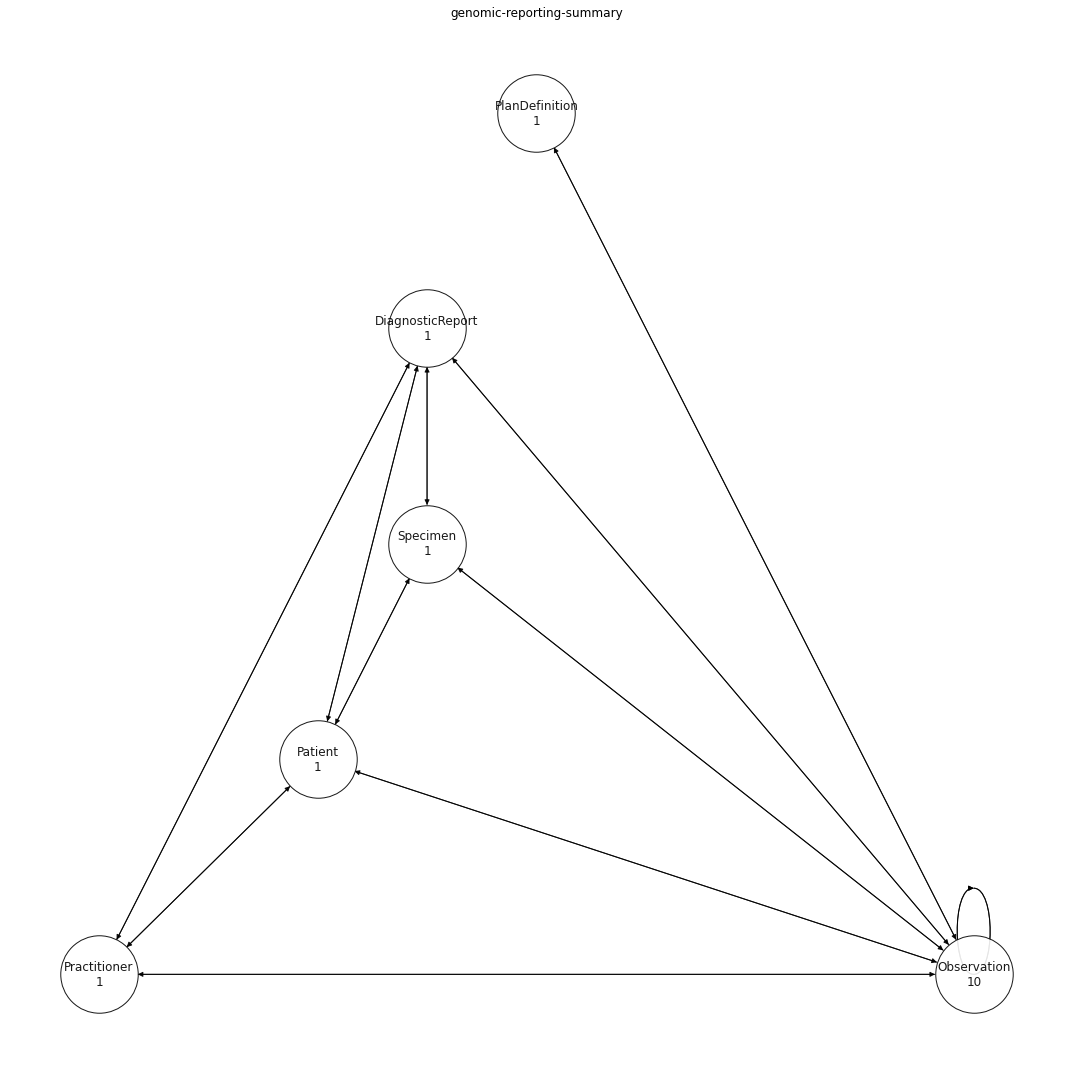

In [4]:
summary_graph = summarize_graph(graph)
path = os.path.join('/tmp/', 'genomic-reporting-summary.png')
draw_graph(summary_graph, path=path)

### Retrieve all Patients

In [5]:
# "retrieve" the patients
patients = find_by_resource_type(graph, 'Patient')
# count the tuples that returned
assert len(patients) == 1, "should have 1 patients"
# get the FHIR resource
patients = [dict_['resource'] for id_, dict_ in patients]


### Show details

In [6]:
pd.DataFrame([flatten(patient.as_json()) for patient in patients] )

,id,text_status,text_div,identifier_0_value,name_0_given_0,name_0_given_1,name_0_given_2,gender,birthDate,generalPractitioner_0_reference,resourceType
0,Inline-Instance-for-oncologyexamples-r4-1,generated,"<div xmlns=""http://www.w3.org/1999/xhtml""><p><...",1007,Carrot,John,Mr,male,1962-12-31,Practitioner/Inline-Instance-for-oncologyexamp...,Patient


### Show simplified details

> 1/3 the number of columns

In [7]:
pd.DataFrame([flatten(patient.as_simplified_json()[0]) for patient in patients] )

,id,text_status,text_div,identifier_,name_given_0,name_given_1,name_given_2,gender,birthDate,generalPractitioner_reference
0,Inline-Instance-for-oncologyexamples-r4-1,generated,"<div xmlns=""http://www.w3.org/1999/xhtml""><p><...",1007,Carrot,John,Mr,male,1962-12-31,Practitioner/Inline-Instance-for-oncologyexamp...


## Navigate using FHIR references

In [8]:
diagnostic_reports = [dict_['resource'] for id_, dict_ in find_by_resource_type(graph, 'DiagnosticReport')]
patients = set([graph.nodes.get(diagnostic_report.subject.reference)['resource'] for diagnostic_report in diagnostic_reports])
f"diagnostic_report: {len(diagnostic_reports)} patients: {len(patients)}"

'diagnostic_report: 1 patients: 1'

In [9]:
pd.DataFrame([diagnostic_reports[0].as_simplified_json()[0]] )

,id,meta,text,status,category,code,subject,performer,specimen,result
0,Inline-Instance-for-oncologyexamples-r4-13,{'profile': 'http://hl7.org/fhir/uv/genomics-r...,"{'status': 'generated', 'div': '<div xmlns=""ht...",final,{'coding_v2-0074': 'GE'},"{'coding_loinc.org': '81247-9', 'text': 'Genet...",{'reference': 'Patient/Inline-Instance-for-onc...,{'reference': 'Practitioner/Inline-Instance-fo...,{'reference': 'Specimen/Inline-Instance-for-on...,[{'reference': 'Observation/Inline-Instance-fo...


In [10]:
# The `results` of a diagnostic report are observations

observations = [graph.nodes.get(result.reference)['resource'] for result in diagnostic_reports[0].result]

### Create Observation data frame

In [11]:
records = []

for o in observations:
    attributes = {
            'subject': o.subject.reference if o.subject else None,
            'specimen': o.specimen.reference if o.specimen else None,
            'code': o.code.text if o.code.text else o.code.coding[0].display,
            'valueQuantity': o.valueQuantity.value if o.valueQuantity else None,
            'valueQuantity_unit': o.valueQuantity.unit if o.valueQuantity else None,
            'valueCodeableConcept': o.valueCodeableConcept.coding[0].display if o.valueCodeableConcept else None
        }
    components = {}
    if o.component:
        components =  {
            c.code.coding[0].display if c.code.coding[0].display else c.code.coding[0].code:
            c.valueCodeableConcept.coding[0].display if c.valueCodeableConcept.coding else c.valueCodeableConcept.text
            for c in o.component
        }        
    records.append({**attributes, **components})

pd.DataFrame(records).fillna('')    

,subject,specimen,code,valueQuantity,valueQuantity_unit,valueCodeableConcept,Genomic DNA change (gHGVS),Amino acid change (pHGVS),Amino acid change type,Genomic source class,Gene studied ID,predicted-therapeutic-implication,Level of Evidence,81259-4,Medication assessed
0,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,Genetic variant assessment,,,Present,9:g.5073770G>T,p.Val617Phe,Missense,Germline,JAK2,,,,
1,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,Genetic variant assessment,,,Present,4:g.55972974T>A,p.Gln472His,Missense,Germline,KDR,,,,
2,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,Genetic variant assessment,,,Present,2:g.212578380del,,Missense,Germline,ERBB4,,,,
3,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,Tumor Mutational Burden,25.0,somatic variants per megabase of sequenced DNA,,,,,,,,,,
4,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,MSI status,,,,,,,,,,,,
5,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,Therapeutic Implication,,,,,,,,,Responsive,Very strong evidence pathogenic,Polycythemia vera (PV),Ruxolitinib
6,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,Therapeutic Implication,,,,,,,,,Responsive,Very strong evidence pathogenic,Polycythemia vera (PV),AT9283
7,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,Therapeutic Implication,,,,,,,,,Responsive,Very strong evidence pathogenic,Polycythemia vera (PV),SNX-5422
8,Patient/Inline-Instance-for-oncologyexamples-r4-1,Specimen/Inline-Instance-for-oncologyexamples-...,Therapeutic Implication,,,,,,,,,Responsive,Very strong evidence pathogenic,Polycythemia vera (PV),TG02
